In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math
import itertools
from IPython.display import HTML
from matplotlib import cm

# compose the NN model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Input, Dropout
from tensorflow.keras import backend as K
from tensorflow.keras.utils import get_custom_objects
from keras.datasets import mnist
from keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam
from keras.layers import Flatten, Conv2D, MaxPooling2D

seed=0
np.random.seed(seed) # fix random seed
tf.random.set_seed(seed)

In [65]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<a href="javascript:code_toggle()">Mostra/Nascondi celle</a>.''')

# <span style="color:green"> Numerical Simulation Laboratory (NSL) </span>
# Valentina Guarino, mat. 978477

## <span style="color:red">  ESERCITAZIONE 12</span>

### Riconoscimento immagini con DNN e CNN

Scopo dell'esercitazione è riuscire a risolvere un problema di classificazione, ovvero il riconoscimento di una serie di immagini raffiguranti numeri da $0$ a $9$, prese dal dataset <a href="http://yann.lecun.com/exdb/mnist/">MNIST</a>, tramite l'allenamento di due tipi diversi di reti neurali: una rete neurale profonda **DNN** ed una rete neurale di tipo convoluzionale **CNN**.

#### Convolutional Neural Network

Le CNN si distinguono dalle classiche reti profonde poiché non effettuano una moltiplicazione tra matrici bensì una _convoluzione_ tra una matrice multidimensionale di dimensione $m$ (come può essere rappresentata un'immagine) e una matrice più piccola, chiamata _kernel_, di dimensione $k << m$. La matrice di kernel viene fatta scorrere lungo tutta la matrice di input, e per ogni coordinata $(x, y)$ di quest'ultima viene effettuata la convoluzione con la matrice di kernel per ogni sua coordinata vicina, in base alla dimensionalità del kernel.

<img src="convolutions_kernel_sliding.jpg" alt="kernel" width="220" heigth="220" />

Ogni layer di convoluzione produce delle attivazioni lineari; a queste vengono applicate delle funzioni di attivazioni non lineari (come ad esempio una **ReLU**) in uno stadio detto _detector stage_. Successivamente viene applicato un layer detto di _pooling_, che modifica i dati di output riducendone le dimensioni tramite delle statistiche operate su di essi. Ad esempio il **_max pooling_** sceglie come dato di output il massimo che si ha nell'intorno.

<img src="pooling.jpg" alt="pooling" width="300" heigth="300" />

I dati di output che si ottengono dopo l'applicazione di vari _layers di convoluzione_ (formati da convoluzione, detector stage e pooling) vengono poi fatti analizzare da layers di tipo denso. 

### Esercizio 12.01

Utilizzando una DNN per il riconoscimento delle immagini del database MNIST, si vuole valutare come cambia la performance del modello al variare del tipo di ottimizzatore. 
Gli ottimizzatori variano principalmente per la scelta dei **learning rates**, che mi danno l'ampiezza dei passi da effettuare lungo il gradiente, e la presenza o meno del **momento**, che velocizza la discesa del gradiente in una certa direzione e smorza le oscillazioni.

In particolare verrà valutata l'andamento della loss e della accuracy, per set di training e di validazione, con l'utilizzo dei seguenti ottimizzatori:

- **SGD**: ottimizzatore che utilizza una discesa del gradiente stocastica. La learning rate è fissata a 0.01 per tutti gli update dei pesi.

- **Adagrad**: ottimizzatore con learning rate che viene adattata in base a quanto frequentemente viene fatto l'update di un parametro durante l'allenamento. Più questo avviene, più piccola è la learning rate associata.

- **Adadelta**: estensione dell'ottimizzatore Adagrad; non accumula tutti i gradienti computati in precedenza, ma accumula solo quelli che si trovano in una finestra di una certa taglia.

- **Adam**: estensione di Adagrad e RMSProp, fa una stima adattativa dei momenti del primo e del secondo ordine. Simile ad un ottimizzatore RMSProp, ma con uso del momento.

- **Adamax**: estensione di Adam, basata su una norma infinita.

- **Nadam**: estensione di Adam, con uso di un momento di Nesterov.

Vengono caricati i dati dal MNIST, i quali sono formati da:

In [3]:
# input image dimensions
img_rows, img_cols = 28, 28 # number of pixels 
# output
num_classes = 10 # 10 digits

# the data, split between train and test sets
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

print(X_train.shape[0], 'campioni nel set di training')
print(X_test.shape[0], 'campioni nel set di validazione')

60000 campioni nel set di training
10000 campioni nel set di validazione


I vettori delle label vengono convertiti in matrici binarie, in modo da poter effettuare una classificazione nel layer di output.

In [4]:
# reshape data, it could depend on Keras backend
X_train = X_train.reshape(X_train.shape[0], img_rows*img_cols)
X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)

# cast floats to single precision
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# rescale data in interval [0,1]
X_train /= 255
X_test /= 255

In [5]:
# convert class vectors to binary class matrices, e.g. for use with categorical_crossentropy
Y_train = keras.utils.to_categorical(Y_train, num_classes)
Y_test = keras.utils.to_categorical(Y_test, num_classes)

Si utilizza un modello formato da $4$ layers:
- $400$ neuroni nel layer di input, funzione di attivazione ReLU
- $100$ neuroni nel primo hidden layer, funzione di attivazione ReLU
- Layer di **Dropout** con rate $0,5$
- $10$ neuroni per l'output layer, funzione di attivazione softmax

Viene utilizzata sempre la stessa loss function, ovvero una categorical cross-entropy

 $$ L(x) = \frac{1}{N}\sum_{i=1}^{N}\big(\hat{y}_i\cdot\log(y_i)\big) $$
 
 dove $\hat{y}_i$ sono i valori predetti e $y_i$ le true labels.
 
 Variando l'ottimizzatore, si ottengono i seguenti risultati:

In [6]:
def create_DNN():
    # instantiate model
    model = Sequential()
    # add a dense all-to-all relu layer
    model.add(Dense(400,input_shape=(img_rows*img_cols,), activation='relu'))
    # add a dense all-to-all relu layer
    model.add(Dense(100, activation='relu'))
    # apply dropout with rate 0.5
    model.add(Dropout(0.5))
    # soft-max layer
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

In [7]:
### Compilatori con i diversi ottimizzatori valutati ###

def compile_model_SGD():
    model=create_DNN()
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=SGD(),
                  metrics=['acc'])
    return model

def compile_model_Adam():
    model=create_DNN()
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=Adam(),
                  metrics=['acc'])
    return model

def compile_model_Adagrad():
    model=create_DNN()
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=Adagrad(),
                  metrics=['acc'])
    return model

def compile_model_Adadelta():
    model=create_DNN()
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=Adadelta(),
                  metrics=['acc'])
    return model

def compile_model_Adamax():
    model=create_DNN()
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=Adamax(),
                  metrics=['acc'])
    return model

def compile_model_Nadam():
    model=create_DNN()
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=Nadam(),
                  metrics=['acc'])
    return model

In [8]:
# Parametri di training
batch_size = 32
epochs = 15

In [9]:
### Ottimizzatore SGD ###

# Creazione DNN
model_DNN_SGD = compile_model_SGD()

# Allenamento della DNN
history_SGD = model_DNN_SGD.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=0,
          validation_data=(X_test, Y_test))

In [10]:
# Performance modello
score_SGD = model_DNN_SGD.evaluate(X_test, Y_test, verbose=0)

print("Valutazione della performance con un ottimizzatore SGD: \n")
print('Test loss:', score_SGD[0])
print('Test accuracy:', score_SGD[1])

Valutazione della performance con un ottimizzatore SGD: 

Test loss: 0.0861760824918747
Test accuracy: 0.972000002861023


In [11]:
### Ottimizzatore Adam ###

# Creazione DNN
model_DNN_Adam = compile_model_Adam()

# Allenamento della DNN
history_Adam = model_DNN_Adam.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=0,
          validation_data=(X_test, Y_test))

In [12]:
# Performance modello
score_Adam = model_DNN_Adam.evaluate(X_test, Y_test, verbose=0)

print("Valutazione della performance con un ottimizzatore Adam: \n")
print('Test loss:', score_Adam[0])
print('Test accuracy:', score_Adam[1])

Valutazione della performance con un ottimizzatore Adam: 

Test loss: 0.09751208126544952
Test accuracy: 0.9810000061988831


In [13]:
### Ottimizzatore Adagrad ###

# Creazione DNN
model_DNN_Adagrad = compile_model_Adagrad()

# Allenamento della DNN
history_Adagrad = model_DNN_Adagrad.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=0,
          validation_data=(X_test, Y_test))

In [14]:
# Performance modello
score_Adagrad = model_DNN_Adagrad.evaluate(X_test, Y_test, verbose=0)

print("Valutazione della performance con un ottimizzatore Adagrad: \n")
print('Test loss:', score_Adagrad[0])
print('Test accuracy:', score_Adagrad[1])

Valutazione della performance con un ottimizzatore Adagrad: 

Test loss: 0.22419506311416626
Test accuracy: 0.9350000023841858


In [15]:
### Ottimizzatore Adadelta ###

# Creazione DNN
model_DNN_Adadelta = compile_model_Adadelta()

# Allenamento della DNN
history_Adadelta = model_DNN_Adadelta.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=0,
          validation_data=(X_test, Y_test))

In [16]:
# Performance modello
score_Adadelta = model_DNN_Adadelta.evaluate(X_test, Y_test, verbose=0)

print("Valutazione della performance con un ottimizzatore Adadelta: \n")
print('Test loss:', score_Adadelta[0])
print('Test accuracy:', score_Adadelta[1])

Valutazione della performance con un ottimizzatore Adadelta: 

Test loss: 0.6994114518165588
Test accuracy: 0.8511000275611877


In [17]:
### Ottimizzatore Adamax ###

# Creazione DNN
model_DNN_Adamax = compile_model_Adamax()

# Allenamento della DNN
history_Adamax = model_DNN_Adamax.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=0,
          validation_data=(X_test, Y_test))

In [18]:
# Performance modello
score_Adamax = model_DNN_Adamax.evaluate(X_test, Y_test, verbose=0)

print("Valutazione della performance con un ottimizzatore Adamax: \n")
print('Test loss:', score_Adamax[0])
print('Test accuracy:', score_Adamax[1])

Valutazione della performance con un ottimizzatore Adamax: 

Test loss: 0.05637197941541672
Test accuracy: 0.982699990272522


In [19]:
### Ottimizzatore Adamax ###

# Creazione DNN
model_DNN_Nadam = compile_model_Nadam()

# Allenamento della DNN
history_Nadam = model_DNN_Nadam.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=0,
          validation_data=(X_test, Y_test))

In [20]:
# Performance modello
score_Nadam = model_DNN_Nadam.evaluate(X_test, Y_test, verbose=0)

print("Valutazione della performance con un ottimizzatore Nadam: \n")
print('Test loss:', score_Nadam[0])
print('Test accuracy:', score_Nadam[1])

Valutazione della performance con un ottimizzatore Nadam: 

Test loss: 0.10658487677574158
Test accuracy: 0.982200026512146


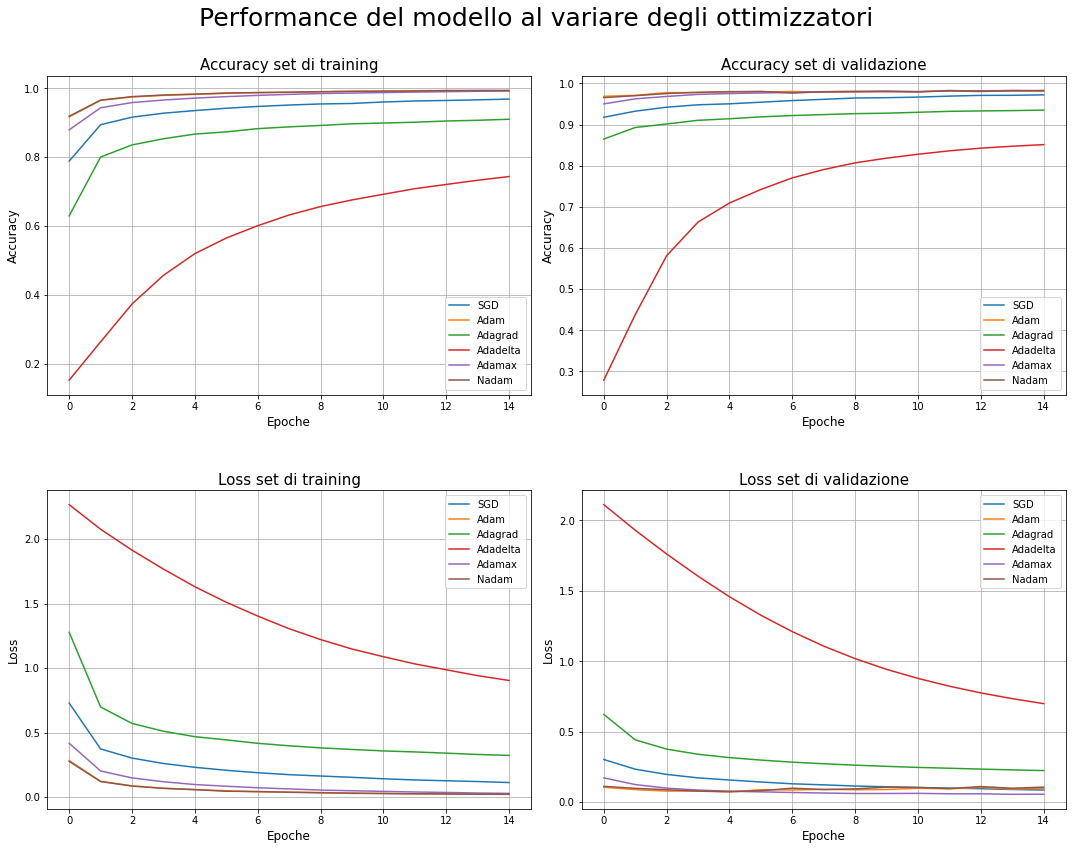

In [21]:
plt.figure(figsize=(15,12))

plt.subplot(2,2,1)
#Plot dell'accuracy
plt.plot(history_SGD.history['acc'], label = "SGD")
plt.plot(history_Adam.history['acc'], label = "Adam")
plt.plot(history_Adagrad.history['acc'], label = "Adagrad")
plt.plot(history_Adadelta.history['acc'], label = "Adadelta")
plt.plot(history_Adamax.history['acc'], label = "Adamax")
plt.plot(history_Nadam.history['acc'], label = "Nadam")
plt.ylabel('Accuracy', fontsize = 12)
plt.xlabel('Epoche', fontsize = 12)
plt.title('Accuracy set di training', fontsize = 15)
plt.legend(loc='best')
plt.grid(True)


plt.subplot(2,2,2)
plt.plot(history_SGD.history['val_acc'], label = "SGD")
plt.plot(history_Adam.history['val_acc'], label = "Adam")
plt.plot(history_Adagrad.history['val_acc'], label = "Adagrad")
plt.plot(history_Adadelta.history['val_acc'], label = "Adadelta")
plt.plot(history_Adamax.history['val_acc'], label = "Adamax")
plt.plot(history_Nadam.history['val_acc'], label = "Nadam")
plt.ylabel('Accuracy', fontsize = 12)
plt.xlabel('Epoche', fontsize = 12)
plt.title('Accuracy set di validazione', fontsize = 15)
plt.legend(loc='best')
plt.grid(True)

plt.subplot(2,2,3)
#Plot della loss function
plt.plot(history_SGD.history['loss'], label = "SGD")
plt.plot(history_Adam.history['loss'], label = "Adam")
plt.plot(history_Adagrad.history['loss'], label = "Adagrad")
plt.plot(history_Adadelta.history['loss'], label = "Adadelta")
plt.plot(history_Adamax.history['loss'], label = "Adamax")
plt.plot(history_Nadam.history['loss'], label = "Nadam")
plt.ylabel('Loss', fontsize = 12)
plt.xlabel('Epoche', fontsize = 12)
plt.title("Loss set di training", fontsize = 15)
plt.legend(loc='best')
plt.grid(True)

plt.subplot(2,2,4)
plt.plot(history_SGD.history['val_loss'], label = "SGD")
plt.plot(history_Adam.history['val_loss'], label = "Adam")
plt.plot(history_Adagrad.history['val_loss'], label = "Adagrad")
plt.plot(history_Adadelta.history['val_loss'], label = "Adadelta")
plt.plot(history_Adamax.history['val_loss'], label = "Adamax")
plt.plot(history_Nadam.history['val_loss'], label = "Nadam")
plt.ylabel('Loss', fontsize = 12)
plt.xlabel('Epoche', fontsize = 12)
plt.title("Loss set di validazione", fontsize = 15)
plt.legend(loc='best')
plt.grid(True)

plt.suptitle("Performance del modello al variare degli ottimizzatori", fontsize = 25)
plt.tight_layout()
plt.subplots_adjust(top=0.9,hspace=0.3)
plt.show()

I risultati migliori si ottengono con gli ottimizzatori **Adam** e **Adamax**. Con l'ottimizzatore **Adamax** si ottengono i risultati più precisi di loss ed accuracy:

Test loss Adamax: $0.05637197941541672$

Test accuracy Adamax: $0.982699990272522$

Inoltre, visionando l'andamento delle curve di loss sul set di validazione, non risulta esserci overfitting dei dati utilizzando un ottimizzatore di tipo **Adamax**; poiché invece la curva di loss relativa ad un ottimizzatore **Adam** tende ad aumentare all'avanzare delle epoche, l'overfitting sembra esserci invece per quest'ultimo caso. 

Dunque l'ottimizzatore **Adamax** risulta dunque il migliore per il problema di riconoscimento di immagini considerato.

Effettuando il riconoscimento di immagini si ottiene il seguente risultato:

In [22]:
### Ottimizzatore Adamax ###

# Creazione DNN
model_DNN_Adamax = compile_model_Adamax()

# Allenamento della DNN
history_Adamax = model_DNN_Adamax.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=0,
          validation_data=(X_test, Y_test))

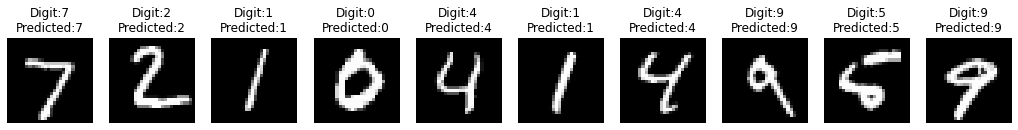

In [23]:
#Predizione
X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)

prediction = model_DNN_Adamax.predict(X_test)

X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols,1)

plt.figure(figsize=(18, 18)) 

for i in range(10):    
    ax = plt.subplot(2, 10, i + 1)    
    plt.imshow(X_test[i, :, :, 0], cmap='gray')    
    plt.title("Digit:{}\nPredicted:{}".format(np.argmax(Y_test[i]), np.argmax(prediction[i])))    
    plt.axis('off') 
plt.show()

Con questo tipo di DNN si è dunque ottenuto un riconoscimento esatto di tutte le cifre in ingresso.

### Esercizio 12.02

Nell'esercizio si vuole effettuare un riconoscimento di immagini utilizzando una rete profonda convoluzionale. 

In particolare si cerca di riconoscere le cifre del database MNIST utilizzando la seguente CNN:

- **_1° hidden layer_**: viene utilizzato un layer di tipo `Conv2D` che utilizza $10$ filtri, con kernel di ampiezza $5x5$ e funzione di attivazione **ReLU**, e successivamente un `MaxPooling2D`, con taglia della finestra di pooling di $3x3$
- **_2° hidden layer_**:  il layer `Conv2D` utilizza stavolta $20$ filtri con kernel di ampiezza $3x3$ mentre la funzione di attivazione resta una **ReLU**; il `MaxPooling2D` ha invece ampiezza $2x2$.
- **_Output layers_**: `Flatten` layer che trasforma i valori di output ottenuti dopo l'applicazione della convoluzione e del pooling in un vettore monodimensionale, $2$ layers di tipo `Dense`, rispettivamente con $200$ e $100$ neuroni e con funzioni d'attivazione **ReLU**, e un layer finale `Dense`con $10$ neuroni e funzione d'attivazione **softmax**, per avere un output in forma categorica

In [24]:
# reshape data, depending on Keras backend
if keras.backend.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [25]:
def create_CNN(nome_modello):
    
    model = tf.keras.Sequential(name = nome_modello)
    
    #Hidden layers
    model.add(Conv2D(10, kernel_size=(5, 5), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Conv2D(20, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    #Output layers
    model.add(Flatten()) 
    model.add(Dense(200, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))  

    #Compilazione del modello
    model.compile(optimizer=Adamax(), loss=keras.losses.categorical_crossentropy, metrics=['acc'])

    return model

In [26]:
model_1 = create_CNN("Modello_1")
model_1.summary()

Model: "Modello_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 10)        260       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 8, 10)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 6, 6, 20)          1820      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 20)          0         
_________________________________________________________________
flatten (Flatten)            (None, 180)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 200)               36200     
_________________________________________________________________
dense_22 (Dense)             (None, 100)               20

Utilizzando come loss function una **categorical cross-entropy**

 $$ L(x) = \frac{1}{N}\sum_{i=1}^{N}\big(\hat{y}_i\cdot\log(y_i)\big) $$
 
 e come ottimizzatore un **Adamax**, otteniamo i seguenti valori di loss ed accuracy:

In [27]:
history_1 = model_1.fit(X_train, Y_train,                 
                            epochs=epochs, batch_size=batch_size, 
                            validation_data=(X_test, Y_test), 
                            shuffle=True, verbose=0)

In [28]:
# Performance modello
score_1= model_1.evaluate(X_test, Y_test, verbose=0)

print("Valutazione della performance del modello: \n")
print('Test loss:', score_1[0])
print('Test accuracy:', score_1[1])

Valutazione della performance del modello: 

Test loss: 0.027748676016926765
Test accuracy: 0.9912999868392944


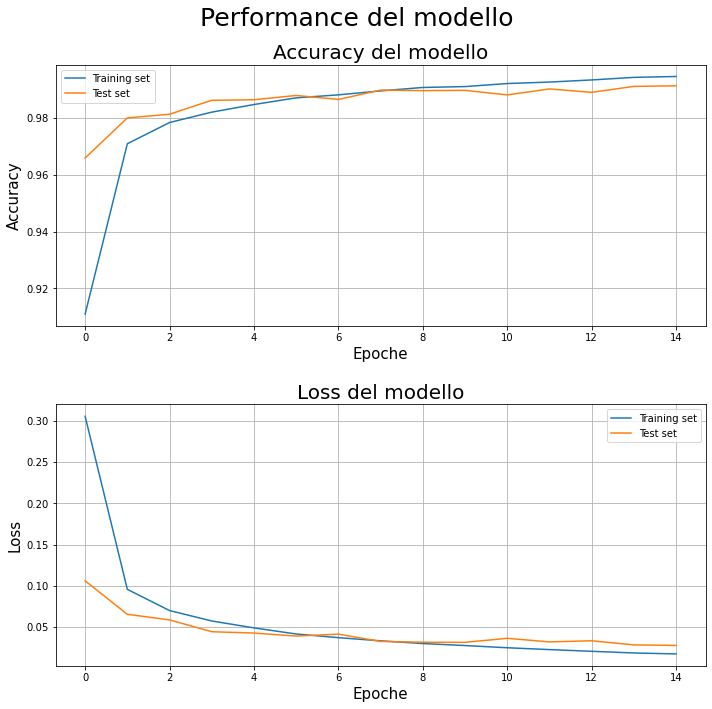

In [29]:
plt.figure(figsize=(10,10))

plt.subplot(2,1,1)
plt.plot(history_1.history['acc'])
plt.plot(history_1.history['val_acc'])
plt.ylabel('Accuracy', fontsize = 15)
plt.xlabel('Epoche', fontsize = 15)
plt.title("Accuracy del modello", fontsize = 20)
plt.legend(['Training set', 'Test set'], loc='best')
plt.grid(True)

plt.subplot(2,1,2)
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.ylabel('Loss', fontsize = 15)
plt.xlabel('Epoche', fontsize = 15)
plt.title("Loss del modello", fontsize = 20)
plt.legend(['Training set', 'Test set'], loc='best')
plt.grid(True)

plt.suptitle("Performance del modello", fontsize = 25)
plt.tight_layout()
plt.subplots_adjust(top=0.9,hspace=0.3)
plt.show()

Nonostante si siano trovati ottimi valori per quanto riguarda la loss e l'accuracy con il modello allenato, si può notare dalla curva relativa alla loss valutata sul test set che, dopo circa $7$ epoche, sembra sorgere un problema di overfitting dei dati.

Si prova allora a generare un secondo modello, in cui viene aggiunto un layer di `Dropout` dopo il secondo layer `Conv2D`: questo fa in modo che durante l'allenamento alcuni neuroni vengono settati a $0$, aumentando la generalizzazione del modello. Nel nostro modello, ciò avviene con una frequenza pari a $0.4$. 

In [30]:
def create_CNN_2(nome_modello):
    model = tf.keras.Sequential(name = nome_modello)
    
    #Hidden layers
    model.add(Conv2D(10, kernel_size=(5, 5), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Conv2D(20, kernel_size=(3, 3), activation='relu'))
    model.add(Dropout(0.4))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    #Output layers
    model.add(Flatten())  
    model.add(Dense(200, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))  

    #Compilazione del modello
    model.compile(optimizer=Adamax(), loss=keras.losses.categorical_crossentropy, metrics=['acc'])

    return model

In [31]:
model_2 = create_CNN_2("Modello_2_Dropout")
model_2.summary()

Model: "Modello_2_Dropout"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 24, 24, 10)        260       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 10)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 6, 20)          1820      
_________________________________________________________________
dropout_7 (Dropout)          (None, 6, 6, 20)          0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 3, 3, 20)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 180)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 200)         

In [32]:
history_2 = model_2.fit(X_train, Y_train,                 
                            epochs=epochs, batch_size=batch_size, 
                            validation_data=(X_test, Y_test), 
                            shuffle=True, verbose=0)

I valori di loss ed accuracy ottenuti con questo nuovo modello sono i seguenti:

In [33]:
# Performance modello
score_2 = model_2.evaluate(X_test, Y_test, verbose=0)

print("Valutazione della performance del modello 2: \n")
print('Test loss:', score_2[0])
print('Test accuracy:', score_2[1])

Valutazione della performance del modello 2: 

Test loss: 0.029763037338852882
Test accuracy: 0.9908999800682068


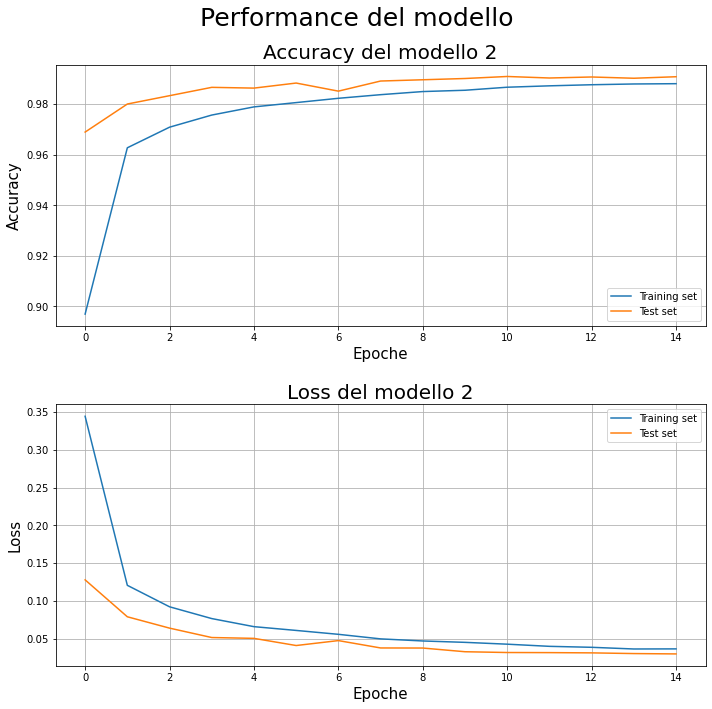

In [34]:
plt.figure(figsize=(10,10))

plt.subplot(2,1,1)
plt.plot(history_2.history['acc'])
plt.plot(history_2.history['val_acc'])
plt.ylabel('Accuracy', fontsize = 15)
plt.xlabel('Epoche', fontsize = 15)
plt.title("Accuracy del modello 2", fontsize = 20)
plt.legend(['Training set', 'Test set'], loc='best')
plt.grid(True)

plt.subplot(2,1,2)
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.ylabel('Loss', fontsize = 15)
plt.xlabel('Epoche', fontsize = 15)
plt.title("Loss del modello 2", fontsize = 20)
plt.legend(['Training set', 'Test set'], loc='best')
plt.grid(True)

plt.suptitle("Performance del modello", fontsize = 25)
plt.tight_layout()
plt.subplots_adjust(top=0.9,hspace=0.3)
plt.show()

Aggiungendo un layer di `Dropout` si è risolto il problema dell'overfitting, come si può vedere dalla curva di loss valutata sul test set. 

Le cifre predette con quest'ultimo modello di CNN sono le seguenti:

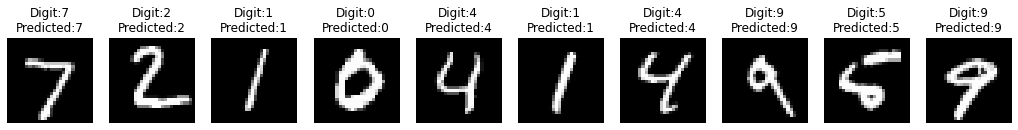

In [35]:
#Predizione

X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols,1)
prediction = model_2.predict(X_test)

plt.figure(figsize=(18, 18)) 

for i in range(10):    
    ax = plt.subplot(2, 10, i + 1)    
    plt.imshow(X_test[i, :, :, 0], cmap='gray')    
    plt.title("Digit:{}\nPredicted:{}".format(np.argmax(Y_test[i]), np.argmax(prediction[i])))    
    plt.axis('off') 
plt.show()

Anche la CNN costruita è riuscita a predirre tutte le cifre in modo accurato.

### Esercizio 12.03

Testiamo le reti create, sia la DNN che la CNN, su due set di $10$ cifre create a mano con il software `GIMP`. 

Il primo set di cifre è stato creato utilizzando un pennello di durezza $50 \%$. Esse risultano un po' sfuocate, e le cifre risultano essere formate prevalentemente da gradazioni di grigio. Le reti svolgono la seguente predizione:

#### DNN - primo set

In [36]:
from PIL import Image
import os

digit_filename = ["Numbers/0.png", "Numbers/1.png", "Numbers/2.png", "Numbers/3.png", "Numbers/4.png", "Numbers/5.png",
                  "Numbers/6.png", "Numbers/7.png", "Numbers/8.png", "Numbers/9.png"]
digit_in = []

for n in range(len(digit_filename)):
    digit_in.append(Image.open(digit_filename[n]).convert('L'))

ydim, xdim = digit_in[0].size
pix = []

for n in range(len(digit_filename)):
    pix.append(digit_in[n].load());
    
data = np.zeros((len(digit_filename), xdim, ydim))

for n in range(len(digit_filename)):
    for j in range(ydim):
        for i in range(xdim):
            data[n][i,j]=pix[n][j,i]
for n in range(len(digit_filename)):
    data[n] /= 255

In [37]:
data_DNN = data.reshape(data.shape[0], xdim*ydim)

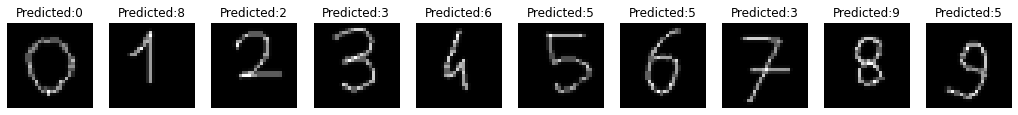

In [38]:
prediction = model_DNN_Adamax.predict(data_DNN)
data_DNN = data_DNN.reshape(data_DNN.shape[0], xdim, ydim, 1)


plt.figure(figsize=(18, 18)) 

for i in range(10):    
    ax = plt.subplot(2, 10, i + 1)    
    plt.imshow(data_DNN[i, :, :, 0], cmap='gray')    
    plt.title("Predicted:{}".format(np.argmax(prediction[i])))    
    plt.axis('off') 
plt.show()

#### CNN - primo set

In [39]:
if tf.keras.backend.image_data_format() == 'channels_first':
    data_CNN = data.reshape(data.shape[0], 1, xdim, ydim)
else:
    data_CNN = data.reshape(data.shape[0], xdim, ydim, 1)

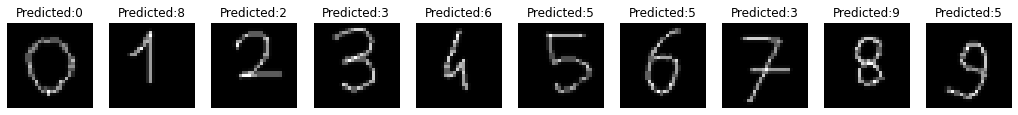

In [40]:
prediction_CNN = model_2.predict(data_CNN)

plt.figure(figsize=(18, 18)) 

for i in range(10):    
    ax = plt.subplot(2, 10, i + 1)    
    plt.imshow(data_CNN[i, :, :, 0], cmap='gray')    
    plt.title("Predicted:{}".format(np.argmax(prediction[i])))    
    plt.axis('off') 
plt.show()

Entrambe le reti hanno ottenuto lo stesso risultato, e sono riuscite a predirre soltanto $4$ cifre ovvero i numeri $0, 2, 3$ e $5$. Non si è ottenuto in questo caso un risultato soddisfacente.

Il secondo set di cifre è stato creato invece utilizzando un pennello di durezza $100 \%$. Le cifre appaiono in questo caso più chiare, e risaltano maggiormente rispetto allo sfondo nero.

Le reti ottengono in questo caso i seguenti risultati:

In [41]:
from PIL import Image
import os

digit_filename = ["Numbers_2/0.png", "Numbers_2/1.png", "Numbers_2/2.png", "Numbers_2/3.png", "Numbers_2/4.png", 
                  "Numbers_2/5.png", "Numbers_2/6.png", "Numbers_2/7.png", "Numbers_2/8.png", "Numbers_2/9.png"]
digit_in = []

for n in range(len(digit_filename)):
    digit_in.append(Image.open(digit_filename[n]).convert('L'))

ydim, xdim = digit_in[0].size
pix = []

for n in range(len(digit_filename)):
    pix.append(digit_in[n].load());
    
data = np.zeros((len(digit_filename), xdim, ydim))

for n in range(len(digit_filename)):
    for j in range(ydim):
        for i in range(xdim):
            data[n][i,j]=pix[n][j,i]
for n in range(len(digit_filename)):
    data[n] /= 255

In [42]:
data_DNN = data.reshape(data.shape[0], xdim*ydim)

#### DNN - secondo set

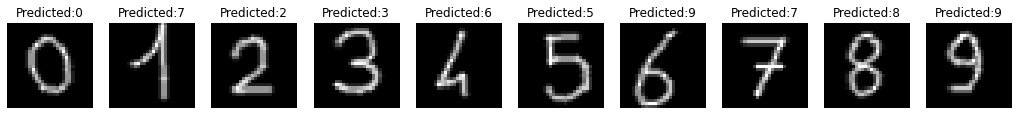

In [43]:
prediction = model_DNN_Adamax.predict(data_DNN)
data_DNN = data_DNN.reshape(data_DNN.shape[0], xdim, ydim, 1)


plt.figure(figsize=(18, 18)) 

for i in range(10):    
    ax = plt.subplot(2, 10, i + 1)    
    plt.imshow(data_DNN[i, :, :, 0], cmap='gray')    
    plt.title("Predicted:{}".format(np.argmax(prediction[i])))    
    plt.axis('off') 
plt.show()

#### CNN - secondo set

In [44]:
if tf.keras.backend.image_data_format() == 'channels_first':
    data_CNN = data.reshape(data.shape[0], 1, xdim, ydim)
else:
    data_CNN = data.reshape(data.shape[0], xdim, ydim, 1)

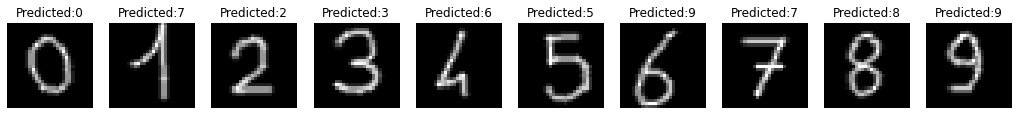

In [45]:
prediction_CNN = model_2.predict(data_CNN)

plt.figure(figsize=(18, 18)) 

for i in range(10):    
    ax = plt.subplot(2, 10, i + 1)    
    plt.imshow(data_CNN[i, :, :, 0], cmap='gray')    
    plt.title("Predicted:{}".format(np.argmax(prediction[i])))    
    plt.axis('off') 
plt.show()

In questo caso i risultati di predizione migliorano per entrambe le reti: esse riescono difatti a predirre correttamente $7$ cifre su $10$, corrispondenti ai numeri $0,2,3,5,7,8$ e $9$. 

La capacità di generalizzazione delle reti create, dunque, dipende anche dalla qualità dei dati di input; con dati di una qualità adeguata come quelli appartenenti al secondo set valutato le reti hanno una discreta capacità di generalizzazione, riuscendo a riconoscere correttamente il $70 \%$ dei dati di input. 
Per provare a migliorare ulteriormente le capacità di generalizzazione si prova ad allenare le reti per un numero di epoche maggiori, pari a $30$ epoche. Si ottengono in questo caso i seguenti risultati:

In [46]:
# Parametri di training
batch_size = 32
epochs = 30

In [47]:
# reshape data, it could depend on Keras backend
X_train = X_train.reshape(X_train.shape[0], img_rows*img_cols)
X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)

In [48]:
# Creazione DNN
model_DNN_Adamax_2 = compile_model_Adamax()

# Allenamento della DNN
history_Adamax_2 = model_DNN_Adamax_2.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=0,
          validation_data=(X_test, Y_test))

In [49]:
# reshape data, depending on Keras backend
if keras.backend.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [50]:
#Creazione CNN
model_CNN_2 = create_CNN_2("Modello_2_Dropout")

#Allenamento CNN
history_CNN_2 = model_CNN_2.fit(X_train, Y_train,                 
                            epochs=epochs, batch_size=batch_size, 
                            validation_data=(X_test, Y_test), 
                            shuffle=True, verbose=0)

In [51]:
from PIL import Image
import os

digit_filename = ["Numbers/0.png", "Numbers/1.png", "Numbers/2.png", "Numbers/3.png", "Numbers/4.png", "Numbers/5.png",
                  "Numbers/6.png", "Numbers/7.png", "Numbers/8.png", "Numbers/9.png"]
digit_in = []

for n in range(len(digit_filename)):
    digit_in.append(Image.open(digit_filename[n]).convert('L'))

ydim, xdim = digit_in[0].size
pix = []

for n in range(len(digit_filename)):
    pix.append(digit_in[n].load());
    
data = np.zeros((len(digit_filename), xdim, ydim))

for n in range(len(digit_filename)):
    for j in range(ydim):
        for i in range(xdim):
            data[n][i,j]=pix[n][j,i]
for n in range(len(digit_filename)):
    data[n] /= 255

In [52]:
data_DNN = data.reshape(data.shape[0], xdim*ydim)

#### DNN - primo set: 30 epoche

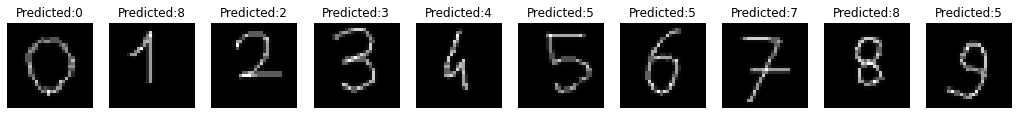

In [53]:
prediction = model_DNN_Adamax_2.predict(data_DNN)
data_DNN = data_DNN.reshape(data_DNN.shape[0], xdim, ydim, 1)


plt.figure(figsize=(18, 18)) 

for i in range(10):    
    ax = plt.subplot(2, 10, i + 1)    
    plt.imshow(data_DNN[i, :, :, 0], cmap='gray')    
    plt.title("Predicted:{}".format(np.argmax(prediction[i])))    
    plt.axis('off') 
plt.show()

#### CNN - primo set: 30 epoche

In [54]:
if tf.keras.backend.image_data_format() == 'channels_first':
    data_CNN = data.reshape(data.shape[0], 1, xdim, ydim)
else:
    data_CNN = data.reshape(data.shape[0], xdim, ydim, 1)

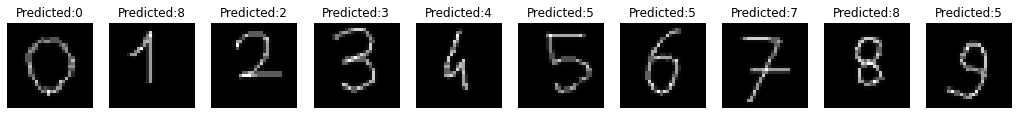

In [55]:
prediction_CNN = model_CNN_2.predict(data_CNN)

plt.figure(figsize=(18, 18)) 

for i in range(10):    
    ax = plt.subplot(2, 10, i + 1)    
    plt.imshow(data_CNN[i, :, :, 0], cmap='gray')    
    plt.title("Predicted:{}".format(np.argmax(prediction[i])))    
    plt.axis('off') 
plt.show()

Per quanto riguarda il primo set di cifre, aumentare il numero di epoche da $15$ a $30$ permette di predirre correttamente $7$ cifre su $10$, corrispondenti ai numeri $0,2,3,4,5,7,8$; si passa dunque dal $40 \%$ di cifre valutate correttamente al $70 \%$.

In [59]:
from PIL import Image
import os

digit_filename = ["Numbers_2/0.png", "Numbers_2/1.png", "Numbers_2/2.png", "Numbers_2/3.png", "Numbers_2/4.png", 
                  "Numbers_2/5.png", "Numbers_2/6.png", "Numbers_2/7.png", "Numbers_2/8.png", "Numbers_2/9.png"]
digit_in = []

for n in range(len(digit_filename)):
    digit_in.append(Image.open(digit_filename[n]).convert('L'))

ydim, xdim = digit_in[0].size
pix = []

for n in range(len(digit_filename)):
    pix.append(digit_in[n].load());
    
data = np.zeros((len(digit_filename), xdim, ydim))

for n in range(len(digit_filename)):
    for j in range(ydim):
        for i in range(xdim):
            data[n][i,j]=pix[n][j,i]
for n in range(len(digit_filename)):
    data[n] /= 255

#### DNN - secondo set: 30 epoche

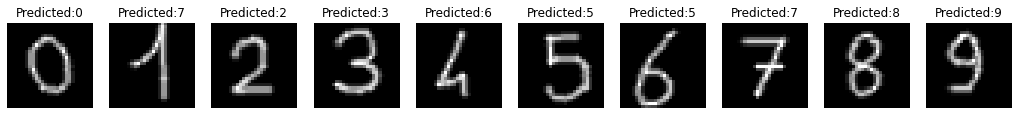

In [60]:
#Predizione
data_DNN = data.reshape(data.shape[0], xdim*ydim)
prediction = model_DNN_Adamax_2.predict(data_DNN)
data_DNN = data_DNN.reshape(data_DNN.shape[0], xdim, ydim, 1)


plt.figure(figsize=(18, 18)) 

for i in range(10):    
    ax = plt.subplot(2, 10, i + 1)    
    plt.imshow(data_DNN[i, :, :, 0], cmap='gray')    
    plt.title("Predicted:{}".format(np.argmax(prediction[i])))    
    plt.axis('off') 
plt.show()

#### CNN - secondo set: 30 epoche

In [61]:
if tf.keras.backend.image_data_format() == 'channels_first':
    data_CNN = data.reshape(data.shape[0], 1, xdim, ydim)
else:
    data_CNN = data.reshape(data.shape[0], xdim, ydim, 1)

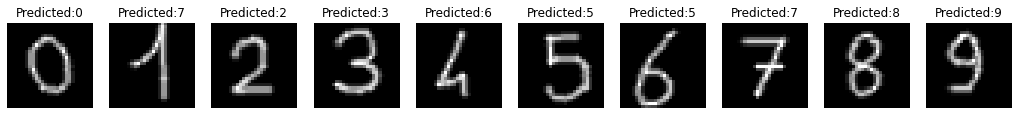

In [62]:
prediction_CNN = model_CNN_2.predict(data_CNN)

plt.figure(figsize=(18, 18)) 

for i in range(10):    
    ax = plt.subplot(2, 10, i + 1)    
    plt.imshow(data_CNN[i, :, :, 0], cmap='gray')    
    plt.title("Predicted:{}".format(np.argmax(prediction[i])))    
    plt.axis('off') 
plt.show()

Per quanto riguarda il secondo set di cifre invece l'aumento delle epoche non porta ad una predizione migliore, che resta stabile al $70 \%$ di cifre corrette valutate. Sulla predizione fatta pesa difatti anche la scrittura individuale: essendo alcune cifre scritte a mano diverse dalle cifre su cui è stata allenata la rete esse non vengono riconosciute, a prescindere dal numero di epoche su cui essa viene allenata.